### LoRA Fine-Tuning with MLX LM

In this notebook, we'll walk through how to [LoRA fine-tune](https://arxiv.org/abs/2106.09685) an LLM with MLX LM. We'll use the [HellaSwag](https://rowanzellers.com/hellaswag/) dataset for common sense reasoning as an example. An outline:

1. Download the dataset and prepare it in the right format for MLX LM.
2. Setup and run LoRA training. We'll show how to capture the training logs and plot some statistics to visualize the performance.
3. Evaluate on the test set. We'll compute the final question-answer accuracy of the fine-tuned model.
4. Fuse the resulting adapters into the base model and upload to Hugging Face.
5. Discuss tips for debugging accuracy and efficiency.

### Install dependencies

In [1]:
!pip install mlx-lm
!pip install matplotlib

### Preprocess Data
We'll start by downloading an already pre-processed version of the HellaSwag dataset from [LLM-Adapters](https://github.com/AGI-Edgerunners/LLM-Adapters).

In [13]:
import json
import numpy as np
from pathlib import Path
from urllib import request

save_dir = "/tmp/hellaswag"

def download_and_save(save_dir):
    base_url = "https://raw.githubusercontent.com/AGI-Edgerunners/LLM-Adapters/main/dataset/hellaswag/"
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    for name in ["train.json", "test.json"]:
        out_file = save_dir / name
        if not out_file.exists():
            request.urlretrieve(base_url + name, out_file)

def load_json(dataset):
    download_and_save(save_dir)
    with open(f"{save_dir}/{dataset}.json", "r") as fid:
        return json.load(fid)

train_set, test_set = load_json("train"), load_json("test")
print(f"HellaSwag stats: {len(train_set)} training examples and {len(test_set)} test examples.")
print("An example:\n")
print(json.dumps(train_set[0], indent=4))

HellaSwag stats: 39905 training examples and 10042 test examples.
An example:

{
    "instruction": "Please choose the correct ending to complete the given sentence: Removing ice from car: Then, the man writes over the snow covering the window of a car, and a woman wearing winter clothes smiles. then\n\nEnding1: , the man adds wax to the windshield and cuts it. Ending2: , a person board a ski lift, while two men supporting the head of the person wearing winter clothes snow as the we girls sled. Ending3: , the man puts on a christmas coat, knitted with netting. Ending4: , the man continues removing the snow on his car.\n\nAnswer format: ending1/ending2/ending3/ending4",
    "input": "",
    "output": "the correct answer is ending4",
    "answer": "ending4"
}


Next, let's split the training set into a training and a validation set. We'll pull out a randomly chosen 10% for validation.

In [21]:
# Seed for reproducibility
np.random.seed(43)
perm = np.random.permutation(len(train_set))
valid_size = int(0.1 * len(train_set))
valid_set = [train_set[i] for i in perm[:valid_size]]
train_set = [train_set[i] for i in perm[valid_size:]]

Finally, put the data splits in the MLX LM training format. The format simply expects the data to be in a container which supports random access to the individual examples (e.g. a Python `list`):
```
["An example for the model.", "Another example for the model.", ...]
```
For more details, see the [documentation on supported formats](https://github.com/ml-explore/mlx-examples/blob/main/llms/mlx_lm/LORA.md#Data).

In [22]:
def preprocess(dataset):
    return [t["instruction"] + "\n" + t["output"] for t in dataset]

train_set, valid_set, test_set = map(preprocess, (train_set, valid_set, test_set))

### Fine-Tune

For fine-tuning, we'll use Microsoft's [Phi-3 mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct). At 3.8 billion parameters, Phi-3 mini is a high-quality model that is also fast to fine-tune on most Apple silicon machines. Also, it has a [permissive MIT License](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct/blob/main/LICENSE).

First, import all the packages and functions we need.

In [14]:
import matplotlib.pyplot as plt
import mlx.core as mx
import mlx.optimizers as optim
from mlx.utils import tree_flatten
from mlx_lm import load, generate
from mlx_lm.tuner import train, evaluate, TrainingArgs
from mlx_lm.tuner import linear_to_lora_layers
import tqdm

Next, setup the LoRA parameters and make the training arguments. See the [training argument class](https://github.com/ml-explore/mlx-examples/blob/81318ad4a8b2ca5fd1431a42db2b0244d16be851/llms/mlx_lm/tuner/trainer.py#L31-L63) for a more detailed list of training parameters. 

Recall the LoRA update is $W^\top \mathbf{x} + c \cdot \mathbf{a} \mathbf{b}^\top \mathbf{x}$ where $\mathbf{a}$ has shape `(D, rank)`.

With that in mind, the LoRA parameters to attend to are:
- `lora_layers`: The number of Transformer blocks from the top of the model to adapt.
- `rank`: The rank of the low-rank adapters. A larger rank implies more adapter parameters per linear layer.
- `scale`: This is the constant $c$ that scales the low-rank update.

In [33]:
# Make a directory to save the adapter config and weights
adapter_path = Path("adapters")
adapter_path.mkdir(parents=True, exist_ok=True)

lora_config = {
 "lora_layers": 8,
 "lora_parameters": {
    "rank": 8,
    "scale": 20.0,
    "dropout": 0.0,
}}

# Save the LoRA config to the adapter path
with open(adapter_path / "adapter_config.json", "w") as fid:
    json.dump(lora_config, fid, indent=4)    

training_args = TrainingArgs(
    adapter_file=adapter_path / "adapters.safetensors",
    iters=200,
    steps_per_eval=50
)

Next, load the Phi-3 mini model. Note this may take a few minutes to download from HuggingFace if you haven't downloaded it before.

In [ ]:
model_path = "microsoft/Phi-3-mini-4k-instruct"
model, tokenizer = load(model_path)

After loading the model, freeze it's parameters so we don't train them. Then convert linear layers to LoRA layers using the MLX LM utility `linear_to_lora_layers`. The adapters in the `LoRA` layers are not frozen, so they will be included in the model's `trainable_parameters`. Check-out the [LoRA layer implementation](https://github.com/ml-explore/mlx-examples/blob/81318ad4a8b2ca5fd1431a42db2b0244d16be851/llms/mlx_lm/tuner/lora.py#L72-L104) to see how it all works.

By default, MLX LM only adapts the query, key, and value projection matrices for Phi-3. You can specify the layers to adapt by setting `lora_parameters["keys"]` to a list of layer names. In this case it defaults to `["attn.qkv_proj"]`. 

In [19]:
# Freeze the base model
model.freeze()

# Convert linear layers to lora layers
linear_to_lora_layers(model, lora_config["lora_layers"], lora_config["lora_parameters"])

num_train_params = (
    sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
)
print(f"Number of trainable parameters: {num_train_params}")

Number of trainable parameters: 786432


Now we're ready to put it all together and actually train the model. We'll use `Adam` for the optimizer, but you can specify any [optimizer](https://ml-explore.github.io/mlx/build/html/python/optimizers/common_optimizers.html) with any [scheduler](https://ml-explore.github.io/mlx/build/html/python/optimizers/schedulers.html). We also added a custom class to capture the training and validation loss to plot it later.

In [23]:
# Put the model in training mode:
model.train()

# Make the optimizer:
opt = optim.Adam(learning_rate=1e-5)

# Make a class to record the training stats:
class Metrics:
    train_losses = []
    val_losses = []
    def on_train_loss_report(self, info):
        self.train_losses.append((info["iteration"], info["train_loss"]))
    def on_val_loss_report(self, info):
        self.val_losses.append((info["iteration"], info["val_loss"]))

metrics = Metrics()

# Train model:
train(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    optimizer=opt,
    train_dataset=train_set,
    val_dataset=valid_set,
    training_callback=metrics,
)

Starting training..., iters: 200
Iter 1: Val loss 2.687, Val took 32.210s
Iter 10: Train loss 2.456, Learning Rate 1.000e-05, It/sec 0.511, Tokens/sec 583.542, Trained Tokens 11412, Peak mem 14.235 GB
Iter 20: Train loss 2.328, Learning Rate 1.000e-05, It/sec 0.708, Tokens/sec 605.538, Trained Tokens 19963, Peak mem 14.235 GB
Iter 30: Train loss 2.062, Learning Rate 1.000e-05, It/sec 0.621, Tokens/sec 625.616, Trained Tokens 30034, Peak mem 14.235 GB
Iter 40: Train loss 1.856, Learning Rate 1.000e-05, It/sec 0.577, Tokens/sec 613.944, Trained Tokens 40670, Peak mem 14.235 GB
Iter 50: Val loss 1.808, Val took 30.444s
Iter 50: Train loss 1.872, Learning Rate 1.000e-05, It/sec 4.770, Tokens/sec 5100.991, Trained Tokens 51365, Peak mem 14.235 GB
Iter 60: Train loss 1.904, Learning Rate 1.000e-05, It/sec 0.588, Tokens/sec 640.415, Trained Tokens 62257, Peak mem 14.235 GB
Iter 70: Train loss 1.737, Learning Rate 1.000e-05, It/sec 0.603, Tokens/sec 648.153, Trained Tokens 73010, Peak mem 14.2

The adapters are saved every 100 iterations along with the final adapters in `adapters.safetensors`.

In [ ]:
!ls adapters/

Next, let's plot the training and validation losses to see how well the adapters fit the data.

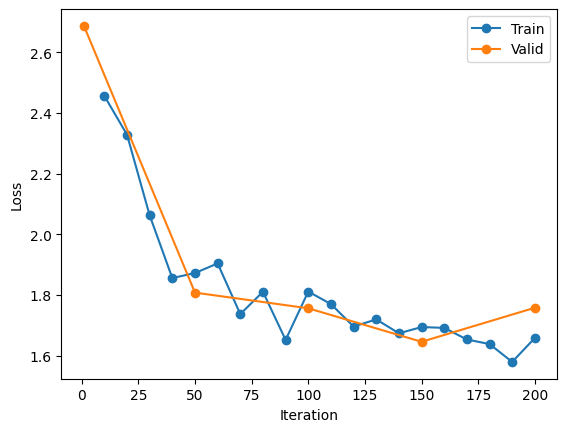

In [24]:
train_its, train_losses = zip(*metrics.train_losses)
val_its, val_losses = zip(*metrics.val_losses)
plt.plot(train_its, train_losses, '-o')
plt.plot(val_its, val_losses, '-o')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(['Train', "Valid"]);

### Evaluate

The training and validation loss are only part of the story. For HellaSwag, we ultimately care about how good the model is at answering questions. To asses this, let's generate the actual `ending1`, `ending2`, `ending3`, or `ending4` responses with the fine-tuned model and measure the accuracy.

First, let's split the last word off of each example in the test set to create a prompt without the answer.

In [29]:
test_set = [t.rsplit(" ", maxsplit=1) for t in test_set]

Next, we'll generate the response for each example in the test set and compare it to the ground-truth answer to measure the accuracy.

In [ ]:
# Increase this number to use more test examples
num_test = 100
num_correct = 0
for prompt, answer in tqdm.tqdm(test_set[:num_test]):
    response = generate(model, tokenizer, prompt, max_tokens=2)
    num_correct += (response==answer)

In [31]:
test_acc = num_correct / num_test
print(f"Approximate test accuracy {test_acc:.3f}")

Approximate test accuracy 0.750


### Fuse Adapters

Sometimes its convenient to fuse the adapters into the base model to create a single adapted model. MLX LM has a fuse script just for that.

The adapted weights are: $\tilde{W} = W + c \cdot \mathbf{b}^\top \mathbf{a}$. Note, this process can be destructive if the inputs are in low precision and they have very different magnitudes. Tuning the `scale` parameter, $c$, prior to fine-tuning can improve the model performance after fusion.

To see more options for fusing the model, including how to upload to HuggingFace [check the documentation](https://github.com/ml-explore/mlx-examples/blob/main/llms/mlx_lm/LORA.md#fuse).

In [37]:
!mlx_lm.fuse --model {model_path}

Once the adapters are fused, we can rerun the evaluation using the fused model to make sure it worked. By default the fused model will be saved to `lora_fused_model`.

In [36]:
model, tokenizer = load("lora_fused_model")
num_correct = 0
for prompt, answer in tqdm.tqdm(test_set[:num_test]):
    response = generate(model, tokenizer, prompt, max_tokens=2)
    num_correct += (response==answer)
test_acc = num_correct / num_test
print(f"Approximate test accuracy {test_acc:.3f}")

Approximate test accuracy 0.750


### Troubleshooting

#### Results

To figure out why your LoRA adapters are not working well it's critical to plot both the trianing loss and validation loss over the duration of fine-tuning. There are really only two cases to consider: underfitting or overfitting. And you can figure out which regime you are in based on the above plot.

**Underfitting**: The trianing loss is not low enough and the validation loss closely matches the training loss. You could also measure the accuracy on the training set itself for question-answering style tasks like HellaSwag. If you are in this regime you have a few options to improve the results:

- Use more adapters. Increase `lora_layers` or adapt more of the linear layers within a given block by setting `lora_parameters["keys"]`.
- Use a higher rank. A higher rank means more parameters per adapter.
- If you are using dropout, decrease the droupout rate or turn it off entirely.
- Sometimes, underfitting issues are really optimization issues. In these cases it can be helpful to tune the learning rate or learning rate schedule.
- If none of the above works, try a bigger model. For example, try Phi-3 medium instead of Phi-3 tiny.

**Overfitting**: The trianing loss keeps going down but the validation loss stops going down and even starts to go up. If you are in this regime you also have a few options:

- The best thing to do is to use more trianing data if you have it.
- Contrary to the underfitting regime decreasing the capacity of the model can help. For example, use fewer adapters, a lower LoRA rank, or a smaller model size.
- If you are not using dropout, use it.

If you find your adapters work well pre-fusion but stop working post-fusion, try tuning the `scale` parameter, $c$, prior to fine-tuning. Typically the adapters have a smaller magnitude than the weights, so using a larger scale helps.

#### Memory Use

Fine-tuning a large LM with LoRA requires a machine with a decent amount of memory. Here are some tips to reduce memory use should you need to do so. 

- Try quantization (QLoRA). You can use QLoRA by generating a quantized model with `mlx_lm.convert` and the `-q` flag or by using an already quantized model from HuggingFace.

- Try using a smaller batch size. You can set the `batch_size` parameter in the `TrainingArgs` or pass `--batch-size` if you are using the CLI. The default is 4 so setting this to 2 or 1 will reduce memory consumption. Note, this may slow things down a little..

- Reduce the number of layers to fine-tune with by setting `lora_layers` to a smaller value or passing `--lora-layers` if you are using the CLI. The default is `16`, so you can try `8` or `4`. This reduces the amount of memory needed for back propagation. It may also reduce the quality of the fine-tuned model and you may need to compensate with a larger `rank`.

- Longer examples require more memory. If it makes sense for your data, one thing you can do is break your examples into smaller sequences when making the `train`, `valid`, and `test` data sets.

- Gradient checkpointing lets you trade-off memory use (less) for computation (more) by recomputing instead of storing intermediate values needed by the backward pass. You can use gradient checkpointing by passing `grad_checkpoint=True` to the `TrainingArgs` or the `--grad-checkpoint` flag if using the CLI. Gradient checkpointing will be more helpful for larger batch sizes or sequence lengths with smaller or quantized models.

### Next Steps

- To learn more about MLX check-out the [GitHub repo](http://github.com/ml-explore/mlx) and [documentation](https://ml-explore.github.io/mlx/)
- For more on MLX LM check-out the [MLX LM documentation](https://github.com/ml-explore/mlx-examples/tree/main/llms#readme).
- Check out the other [MLX Examples](https://github.com/ml-explore/mlx-examples/tree/main). These are great as a learning resource or to use as a starting point for a new project.
- We also have an example of [LoRA fine-tuning in MLX Swift](https://github.com/ml-explore/mlx-swift-examples/tree/main/Applications/LoRATrainingExample).